# Data curation

This notebook includes:
- Exploration of Vesiclepedia and Exocarta datasets
- Curation and merging of Vesiclepedia and Exocarta datasets
- Mapping of EV entries to UniProt IDs (via UniProt API)
- Data visualization (number of occurrences, dataset overlap) 
- Functional enrichment analysis of the top EV proteins

Output datasets:
- VPEC_all.csv
- VPEC_mapped.csv
- VP_old_mapped.csv

## Import libraries

In [27]:
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

from matplotlib_venn import venn2

import warnings
warnings.filterwarnings("ignore")

## Define paths

In [28]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'

## Import data sets

### Vesiclepedia

In [29]:
# load raw Vesiclepedia datasets
VP_cargo = pd.read_csv(Data_path + '/raw/vesiclepedia.txt', sep='\t', engine='python')
VP_experiments = pd.read_csv(Data_path + '/raw/vesiclepedia_experiments.txt', sep='\t', engine='python')

# merge experiment details with cargo data frame 
VP = VP_cargo.merge(VP_experiments[["EXPERIMENT ID", "PUBMED ID", "EXPERIMENT DESCRIPTION", "YEAR", "ISOLATION METHOD", 
    "VESICLE TYPE"]], on="EXPERIMENT ID", how="inner")

### Exocarta

In [30]:
# load raw Exocarta datasets
# exocarta_experiments = Data_path + '/raw/exocarta_experiments.txt'
EC = pd.read_csv(Data_path + '/raw/exocarta.csv', sep=';', engine='python')
# EC_experiments = pd.read_csv(exocarta_experiments, sep='\t', engine='python')

### UniProt human proteome

In [31]:
# load all information from UniProt human proteins
UP = pd.read_csv(Data_path + '/Features/UniProt/uniprot_9606.tab', sep='\t', engine='python')

In [32]:
print('Vesiclepedia')
print('Unique genes: ', len(VP['ENTREZ GENE ID'].value_counts()))
print('Unique species: ', len(VP['SPECIES'].value_counts()))
print('Unique experiments:', len(VP['EXPERIMENT ID'].value_counts())) # some experiments not in cargo dataset
print('------------------')
print('Exocarta')
print('Unique genes: ', len(EC['ENTREZ GENE ID'].value_counts()))
print('Unique species: ', len(EC['SPECIES'].value_counts()))

Vesiclepedia
Unique genes:  34913
Unique species:  35
Unique experiments: 1141
------------------
Exocarta
Unique genes:  12210
Unique species:  7


## Data curation

In [33]:
def filtering(df):
    df_copy = df.copy()
    df_copy = df_copy[df_copy['CONTENT TYPE'] == 'protein'] # select proteins
    df_copy = df_copy[df_copy['SPECIES'] == 'Homo sapiens'] # select human proteins
    return df_copy

def instance_count(df): 
    df_copy = df.copy()
    df_copy['OCCURRENCES'] = df_copy.groupby('ENTREZ GENE ID')['ENTREZ GENE ID'].transform('count') # calculate occurrences
    df_copy = df_copy.drop_duplicates(subset=['ENTREZ GENE ID'], keep='first') # keep a single value per protein
    if 'VESICLE TYPE' in df_copy.columns:
        df_copy = df_copy[['ENTREZ GENE ID', 'GENE SYMBOL', 'OCCURRENCES', 'VESICLE TYPE']]  # rename columns 
    else:
        df_copy = df_copy[['ENTREZ GENE ID', 'GENE SYMBOL', 'OCCURRENCES']]  # rename columns 
    return df_copy

### General EV dataset

In [34]:
VP_filtered = filtering(VP)
VP_curated = instance_count(VP_filtered)
print('Number of filtered unique genes in Vesiclepedia:', len(VP_curated))
EC_filtered = filtering(EC)
EC_curated = instance_count(EC_filtered)
print('Number of filtered unique genes in Exocarta:', len(EC_curated))
print('-------------------')
VPEC = pd.concat([VP_curated, EC_curated])
VPEC = VPEC.drop_duplicates(subset=['ENTREZ GENE ID'], keep='first') # keep instances from Vesiclepedia
VPEC = VPEC.drop("VESICLE TYPE", axis=1)
print('Combined number of filtered unique genes:', len(VPEC))

Number of filtered unique genes in Vesiclepedia: 13550
Number of filtered unique genes in Exocarta: 5409
-------------------
Combined number of filtered unique genes: 13648


#### Uniprot ID mapping

Mapping table obtained from Uniprot ID mapping tool (https://www.uniprot.org/id-mapping): Gene ID to UniProtKB 

In [35]:
# import mapping
mapping = pd.read_csv(Data_path + '/Mapping/all_EV_proteins_Entrez_to_Uniprot.tsv' , sep='\t', header=0, 
    names=['ENTREZ GENE ID', 'Uniprot'])
print('Number of Gene ID to Uniprot ID mappings:', len(mapping))

Number of Gene ID to Uniprot ID mappings: 23269


In [36]:
# drop duplicates, keep first entry as this is usually the manually annotated protein
mapping.drop_duplicates(subset=['ENTREZ GENE ID'], inplace=True)
mapping.drop_duplicates(subset=['Uniprot'])
print('Number of unique Entrez to Uniprot mappings:', len(mapping['ENTREZ GENE ID'].unique()))

# remove entries that are not part of the human proteome
mapping = mapping[mapping['Uniprot'].isin(UP['Entry'])]
print('Number of unique Entrez to human proteome Uniprot mappings:', len(mapping['ENTREZ GENE ID'].unique()))
print('Fraction of successfully mapped Entrez IDs: %.2f%%' %(len(mapping['ENTREZ GENE ID'].unique())/len(VPEC)*100))

Number of unique Entrez to Uniprot mappings: 12794
Number of unique Entrez to human proteome Uniprot mappings: 11952
Fraction of successfully mapped Entrez IDs: 87.57%


In [37]:
VPEC_mapped = VPEC.merge(mapping, on="ENTREZ GENE ID")
VPEC_mapped[:5].sort_values("GENE SYMBOL")

,ENTREZ GENE ID,GENE SYMBOL,OCCURRENCES,Uniprot
0,16,AARS,124,P49588
1,34,ACADM,42,P11310
2,38,ACAT1,65,P24752
3,47,ACLY,185,P53396
4,50,ACO2,58,Q99798


### Stringent EV dataset 

This dataset contains only EV proteins detected by high-confidence isolation workflows. The requirement for a study and its workflow to be included are:
- No ExoQuick or Isolation Kits;
- At least three isolation steps that enrich for different properties (e.g., size and density);
- Size or density-based filtration step first;
- No ultracentrifugation as the first step.

In [38]:
isolation_methods = ['Differential centrifugation|Filtration|Ultracentrifugation',
    'Differential centrifugation|Polymer-based precipitation|Ultracentrifugation',
    'Differential centrifugation|Filtration|Ultracentrifugation|Density gradient centrifugation',
    'Differential centrifugation|Filtration|Sucrose density gradient',
    'Differential centrifugation|Filtration|Ultrafiltration',
    'Microfiltration|Differential centrifugation|Ultracentrifugation',
    'Differential centrifugation|Filtration|Ultrafiltration|Ultracentrifugation|Sucrose density gradient',
    'Differential centrifugation|Filtration|Ultrafiltration|Ultracentrifugation',
    'Hydrostatic filtration dialysis|Differential centrifugation|Ultracentrifugation',
    'Differential centrifugation|Ultrafiltration|Ultracentrifugation|Density gradient centrifugation',
    'Differential centrifugation|Sucrose density gradient|Ultracentrifugation',
    'Differential centrifugation|Hydrostatic filtration dialysis|Ultrafiltration',
    'Differential centrifugation|Sucrose density gradient|Diafiltration',
    'Differential centrifugation|Filtration|Ultracentrifugation|Gel filtration',
    'Differential centrifugation|Filtration|Sucrose density gradient|Ultracentrifugation',
    'Filtration|Size exclusion chromatography|Sucrose density gradient',
    'Differential centrifugation|Sucrose density gradient|Size exclusion chromatography',
    'Differential centrifugation|Gel filtration|Ultracentrifugation']

# save included isolation methods as a text file
with open(Data_path + '/curated/Isolation_methods_filtered.txt', 'w') as f:
    for method in isolation_methods:
        f.write(method + '\n')

In [39]:
# filter Vesiclepedia dataset based on workflow for EV isolation
VP_iso = VP[VP["ISOLATION METHOD"].isin(isolation_methods)]

In [40]:
print('Number of filtered unique genes in Vesiclepedia:', len(VP_curated)) # to compare
VP_iso_filtered = filtering(VP_iso)
VP_iso_curated = instance_count(VP_iso_filtered)
print('Number of filtered unique genes in Vesiclepedia (after isolation method filter):', len(VP_iso_curated))

VP_iso_mapped = VP_iso_curated.merge(mapping, on="ENTREZ GENE ID")
print("Number of unique Entrez to human proteome Uniprot mappings:", len(VP_iso_mapped))
print('Fraction of successfully mapped Entrez IDs: %.2f%%' %(len(VP_iso_mapped)/len(VP_iso_curated)*100))

Number of filtered unique genes in Vesiclepedia: 13550
Number of filtered unique genes in Vesiclepedia (after isolation method filter): 6818
Number of unique Entrez to human proteome Uniprot mappings: 6678
Fraction of successfully mapped Entrez IDs: 97.95%


### Compare EV datasets

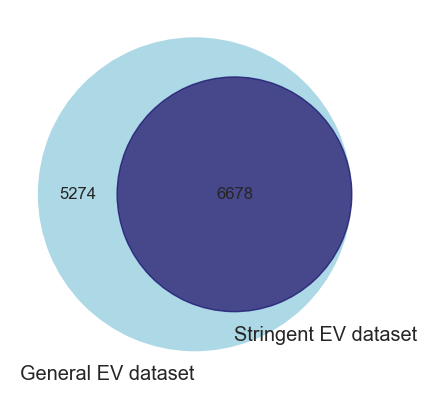

In [41]:
# visualize overlap 
v = venn2([set(VPEC_mapped["ENTREZ GENE ID"]), set(VP_iso_mapped["ENTREZ GENE ID"])], 
      ('General EV dataset', 'Stringent EV dataset'), set_colors=('lightblue', 'midnightblue'), alpha = 1)
v.subset_labels[1].set_visible(False)
v.get_patch_by_id('11').set_color('midnightblue')
v.get_patch_by_id('11').set_alpha(0.8)

plt.show()

### Save data sets

In [42]:
VPEC_mapped.to_csv(Data_path + '/curated/VPEC_all.csv', index=False)
VP_iso_mapped.to_csv(Data_path + '/curated/VP_Isolation_filter.csv', index=False)

### Low confidence EV protein set

Filtering of Vesiclepedia for EV studies published before 2014.

In [43]:
year = 2014

# filter based on the year of the study
VP_pre2014 = VP[VP["YEAR"] < year]

# apply the same filtering as for the other datasets and map to UniProt
VP_pre2014_filtered = filtering(VP_pre2014)
VP_pre2014_curated = instance_count(VP_pre2014_filtered)
# VP_pre2010_curated = instance_count(VP_pre2010)
VP_pre2014_mapped = VP_pre2014_curated.merge(mapping, on="ENTREZ GENE ID")
print("Number of unique Entrez to human proteome Uniprot mappings from studies before 2014:", len(VP_pre2014_mapped))
VP_pre2014_mapped[:5]

Number of unique Entrez to human proteome Uniprot mappings from studies before 2014: 9988


,ENTREZ GENE ID,GENE SYMBOL,OCCURRENCES,VESICLE TYPE,Uniprot
0,16,AARS,52,Microparticles,P49588
1,34,ACADM,12,Microparticles,P11310
2,38,ACAT1,28,Microparticles,P24752
3,47,ACLY,86,Microparticles,P53396
4,50,ACO2,17,Microparticles,Q99798


In [44]:
VP_pre2014_mapped.to_csv(Data_path + '/curated/VP_pre2014_mapped.csv', index=False)
with open(Data_path + '/curated/Low_confidence_EV_proteins.txt', 'w') as f:
    for uniprot in list(VP_pre2014_mapped['Uniprot']):
        f.write(uniprot + '\n')

### High confidence EV protein sets 

The following studies are included in the high confidence EV protein set:
- Plasma: Karimi, N., Cvjetkovic, A., Jang, S.C. et al. Detailed analysis of the plasma extracellular vesicle proteome after separation from lipoproteins. Cell. Mol. Life Sci. 75, 2873–2886 (2018). https://doi.org/10.1007/s00018-018-2773-4
- Urine: Dhondt, B., Geeurickx, E., Tulkens, J., Van Deun, J., Vergauwen, G., Lippens, L., Miinalainen, I., Rappu, P., Heino, J., Ost, P., Lumen, N., De Wever, O. and Hendrix, A. (2020), Unravelling the proteomic landscape of extracellular vesicles in prostate cancer by density-based fractionation of urine. Journal of Extracellular Vesicles, 9: 1736935. https://doi.org/10.1080/20013078.2020.1736935
- Cell culture: Martínez-Greene, J. A., Hernández-Ortega, K., Quiroz-Baez, R., Resendis-Antonio, O., Pichardo-Casas, I., Sinclair, D. A., Budnik, B., Hidalgo-Miranda, A., Uribe-Querol, E., Ramos-Godínez, M. P., & Martínez-Martínez, E. (2021). Quantitative proteomic analysis of extracellular vesicle subgroups isolated by an optimized method combining polymer-based precipitation and size exclusion chromatography. J. Extracell. Vesicles, 10, e12087. https://doi.org/10.1002/jev2.12087

In [45]:
plasma = pd.read_csv(Data_path + "/validation/raw/Karimi2018_plasma_EV_protein_list.txt", sep=" ", header=None, 
    names=["Uniprot"], usecols=[0])
plasma_set = set(plasma["Uniprot"])
print("Number of EV proteins in high confidence plasma dataset:", len(plasma_set))

Number of EV proteins in high confidence plasma dataset: 1187


In [46]:
def get_first_uniprot(string):
    
    if ";" in string:
        first_unirpot, _ = string.split(";", maxsplit=1)
        return first_unirpot
    else: 
        return string
    
urine = pd.read_csv(Data_path + "/validation/raw/Dhondt2021_urine_EV_proteins.csv", sep=";")
urine["Protein IDs"] = urine["Protein IDs"].apply(get_first_uniprot)
urine_set = set(urine["Protein IDs"])
print("Number of EV proteins in high confidence urine dataset:", len(urine_set))

Number of EV proteins in high confidence urine dataset: 1789


In [47]:
culture = pd.read_csv(Data_path + "/validation/raw/MartinezGreene2020_cell_culture_EV_proteins.csv", sep=";")
culture.dropna(axis=0, how="all", inplace=True)
culture_set = set(culture["Accession"])
print("Number of EV proteins in high confidence cell culture dataset:", len(culture_set))

Number of EV proteins in high confidence cell culture dataset: 1686


In [48]:
high_confidence = plasma_set.union(urine_set).union(culture_set)
print("Number of EV proteins in high confidence dataset:", len(high_confidence))

Number of EV proteins in high confidence dataset: 3243


In [49]:
with open(Data_path + '/curated/High_confidence_EV_proteins.txt', 'w') as f:
    for uniprot in high_confidence:
        f.write(uniprot + '\n')

## Functional enrichment analysis of Top EV proteins

In [50]:
# filter for top EV proteins
top_EV_proteins = VP_iso_mapped[VP_iso_mapped['OCCURRENCES'] >= 30]

In [51]:
# enrichment analysis
enr2 = gp.enrichr(gene_list=top_EV_proteins['GENE SYMBOL'], gene_sets='KEGG_2019_Human', cutoff=0.5)

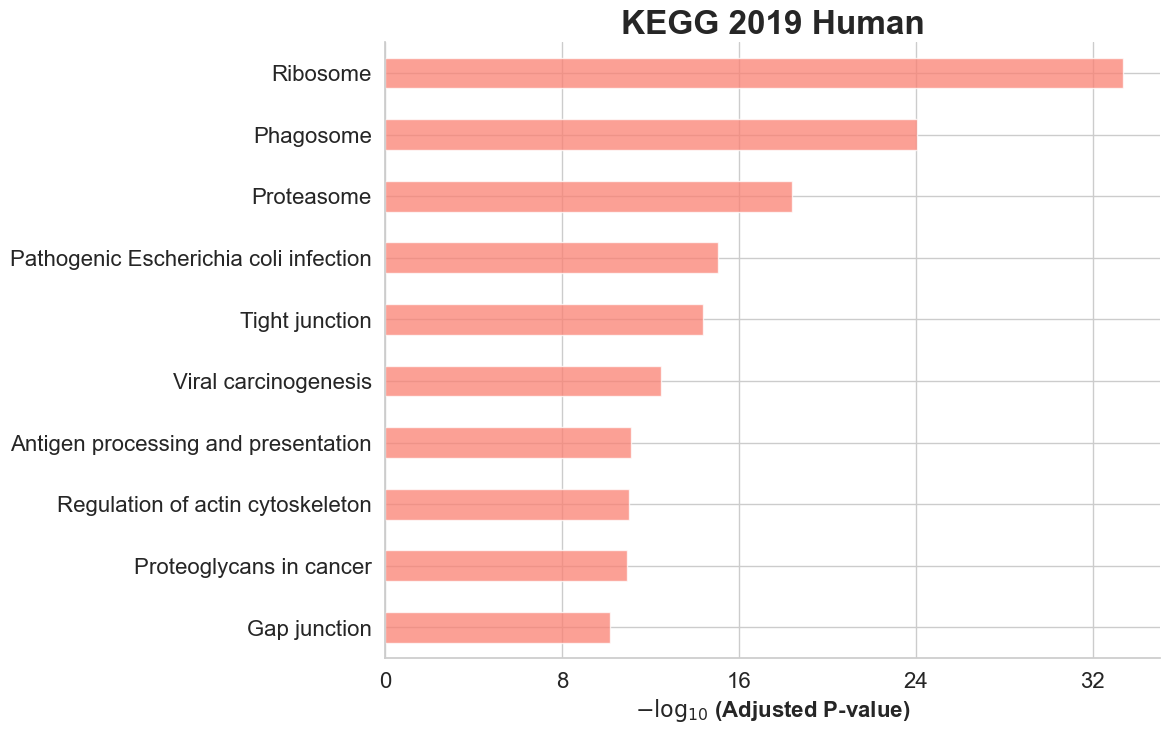

In [52]:
sns.set(font_scale=1, style="whitegrid")
gp.plot.barplot(enr2.res2d, title='KEGG 2019 Human', figsize=(10,8))

plt.show()